In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Data Preprocessing

In [4]:
# Load dataset
file_path = "C:/Users/ashis/OneDrive/Desktop/household_power/household_power_consumption.txt"
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values='?')

# Convert Date and Time into a single Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set Datetime as index for time series analysis
df.set_index('Datetime', inplace=True)

# Drop original Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Resampling data to daily mean for trend visualization
df_daily = df.resample('D').mean()

# Handle missing values by forward filling
df_daily.fillna(method='ffill', inplace=True)

# Detect and remove outliers using Z-score method
z_scores = np.abs((df_daily - df_daily.mean()) / df_daily.std())
outlier_threshold = 3  # Common threshold for outlier detection
df_daily = df_daily[(z_scores < outlier_threshold).all(axis=1)]

C:\Users\ashis\AppData\Local\Temp\ipykernel_12796\2451000859.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily.fillna(method='ffill', inplace=True)


# Plot heatmap of correlations

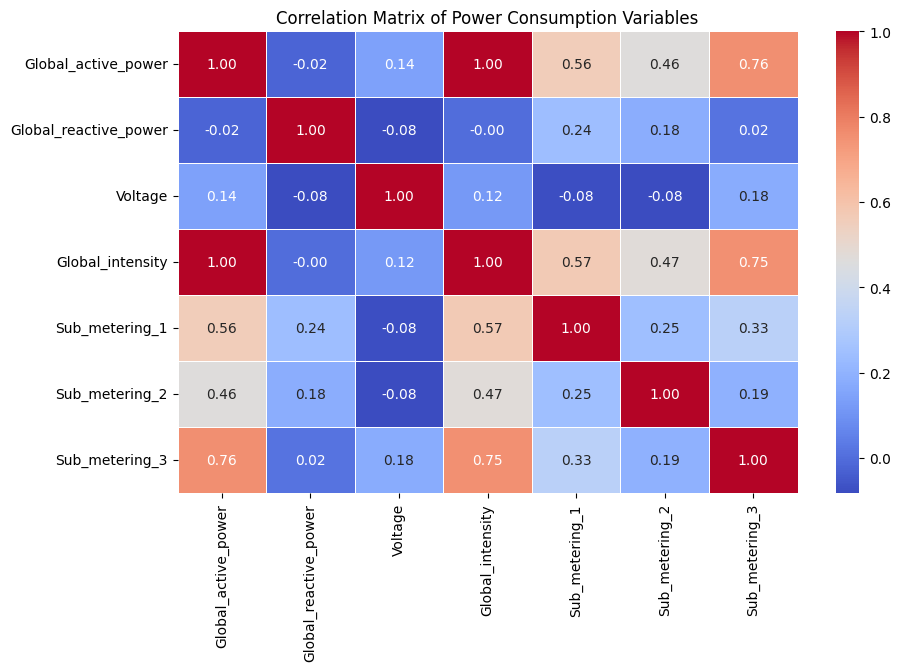

In [5]:
# Compute correlation matrix
corr_matrix = df_daily.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Power Consumption Variables")
plt.show()

# Model Training

In [6]:
# Split data into features and target
X = df_daily.drop(columns=['Global_active_power'])  # Features
y = df_daily['Global_active_power']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model for power consumption prediction
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.00016306111932894323
R-squared Score: 0.9988028803954853


# actual vs predicted values

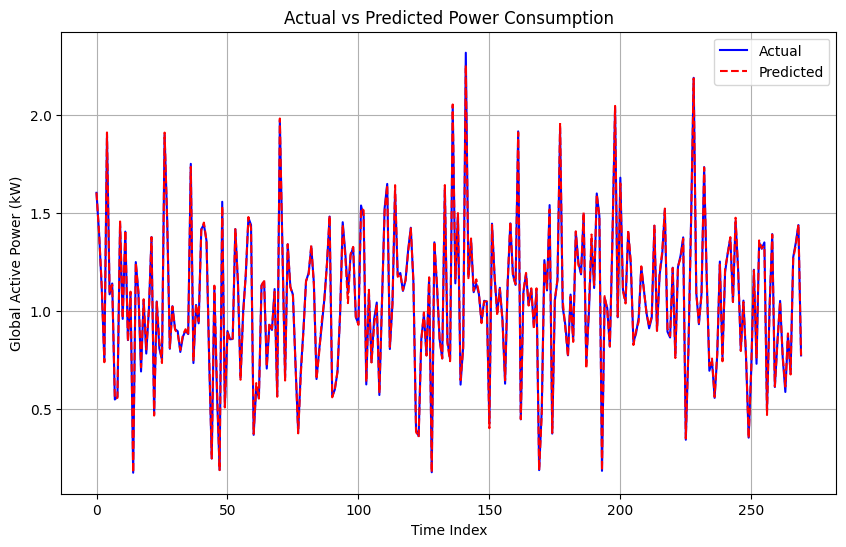

In [7]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='b')
plt.plot(y_pred, label='Predicted', color='r', linestyle='dashed')
plt.xlabel('Time Index')
plt.ylabel('Global Active Power (kW)')
plt.title('Actual vs Predicted Power Consumption')
plt.legend()
plt.grid()
plt.show()

# Machine Learning-based anomaly detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_daily['Anomaly_Score'] = iso_forest.fit_predict(df_daily[['Global_active_power']])

# Highlight anomalies detected by Isolation Forest
df_ml_anomalies = df_daily[df_daily['Anomaly_Score'] == -1]

# ML-based anomalies

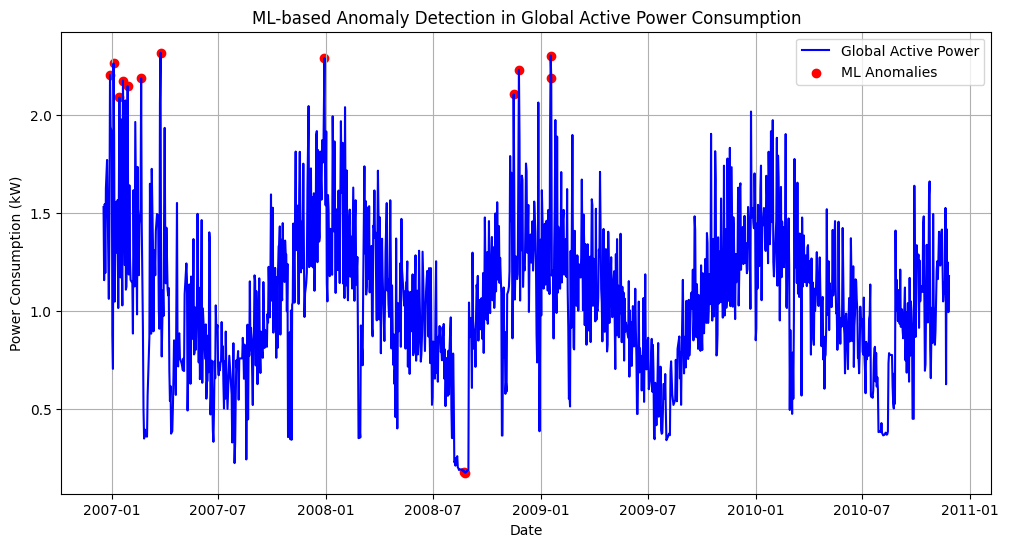

In [8]:
# Plot ML-based anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Global Active Power', color='b')
plt.scatter(df_ml_anomalies.index, df_ml_anomalies['Global_active_power'], color='r', label='ML Anomalies', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Consumption (kW)')
plt.title('ML-based Anomaly Detection in Global Active Power Consumption')
plt.legend()
plt.grid()
plt.show()

In [9]:
import pickle   

In [11]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)